### WGCNA

Looking for modules of coexpressed transcripts in the variance stabilized transformed count data from `DESeq2` and relating them to trait data (i.e. infection status, range, etc.). Here are some good resources for learning more about how to apply WGCNA to our data set:

[WGCNA tutorials](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/)

[Harvard WGCNA walkthrough](http://pklab.med.harvard.edu/scw2014/WGCNA.html)

Peter Langfelder blog posts: [categorical data](https://peterlangfelder.com/2018/11/25/working-with-categorical-variables/), [signed vs. unsigned](https://peterlangfelder.com/2018/11/25/signed-or-unsigned-which-network-type-is-preferable/), [signed vs. signed hybrid](https://peterlangfelder.com/2018/11/25/__trashed/)

[Matz lab code](https://github.com/sbarfield/tagSeq-commonGarden/blob/master/WGCNA_common_garden.r)

If you have already performed module construction (steps `adjacency()`, `TOMsimilarity()`, and `flashClust()`) and saved the output (`dissTOM` and `geneTree`), you can skip all steps through module construction and load in saved objects for downstream use.

Load in the package.

In [1]:
library(WGCNA)
options(stringsAsFactors = FALSE)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor



## Infected vs. uninfected

At this stage, we'll just do bulk comparisons between parasitized and control, using the transformed counts that include the FP samples.

Read in the data. 

In [2]:
vsd <- read.table("../outputs/WGCNA_FP_in.tsv", sep="\t")

Take a look.

In [3]:
head(vsd)
dim(vsd)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_P_1,AP_P_2,AP_P_3,AP_P_6,FP_C_10,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN38930_c0_g1_i1,6.599337,7.301200,6.272945,6.118459,6.108455,6.373066,6.380023,6.841077,6.322121,6.987889,...,6.364875,5.683478,6.300686,6.957383,5.733053,5.888590,5.925657,6.195579,7.112483,6.164760
TRINITY_DN27848_c0_g1_i1,5.479534,6.497937,5.238994,5.645846,6.309932,4.571687,5.892368,3.029977,6.097748,5.613913,...,5.030780,5.703855,5.515910,5.075895,5.612422,5.584078,5.698289,5.839333,3.696704,5.796559
TRINITY_DN134395_c0_g1_i1,6.761378,6.900692,4.195106,4.232515,5.508255,3.881420,3.029977,4.088702,3.029977,7.006694,...,4.433629,3.870438,6.271083,5.340445,3.620086,5.766227,3.972867,3.500558,3.964842,4.457192
TRINITY_DN144418_c0_g1_i1,6.806604,7.460290,5.584432,6.888314,7.171894,5.690711,6.687611,4.313215,7.756181,6.647517,...,7.217553,7.308170,5.197189,5.387534,6.616272,5.631937,6.990374,7.411542,4.473192,6.635868
TRINITY_DN25283_c0_g1_i1,5.080379,5.324406,5.422809,5.615862,5.608972,5.462982,5.253737,5.404613,5.728572,5.335961,...,5.374485,5.531641,6.162284,5.477015,5.358921,5.482989,5.425578,6.028776,4.330813,5.498088
TRINITY_DN21478_c0_g1_i1,5.131219,7.261841,6.504823,7.296233,7.009205,8.142585,8.514580,6.141348,8.685672,7.131835,...,6.106014,6.193052,6.929376,7.676309,6.406596,7.977091,7.946574,7.262589,6.062508,7.826189


[1] 43545    77

Looks good. Now let's transpose it.

In [4]:
vsd <- t(vsd)
vsd[1:6,1:6]
dim(vsd)

,TRINITY_DN38930_c0_g1_i1,TRINITY_DN27848_c0_g1_i1,TRINITY_DN134395_c0_g1_i1,TRINITY_DN144418_c0_g1_i1,TRINITY_DN25283_c0_g1_i1,TRINITY_DN21478_c0_g1_i1
AP_C_1,6.599337,5.479534,6.761378,6.806604,5.080379,5.131219
AP_C_2,7.301200,6.497937,6.900692,7.460290,5.324406,7.261841
AP_C_3,6.272945,5.238994,4.195106,5.584432,5.422809,6.504823
AP_C_4,6.118459,5.645846,4.232515,6.888314,5.615862,7.296233
AP_C_5,6.108455,6.309932,5.508255,7.171894,5.608972,7.009205
AP_P_1,6.373066,4.571687,3.881420,5.690711,5.462982,8.142585


[1]    77 43545

Now we check to see if there are any genes or samples with too many missing values.

In [5]:
gsg = goodSamplesGenes(vsd, verbose = 3)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

Good. Now we'll cluster the samples to identify outliers.

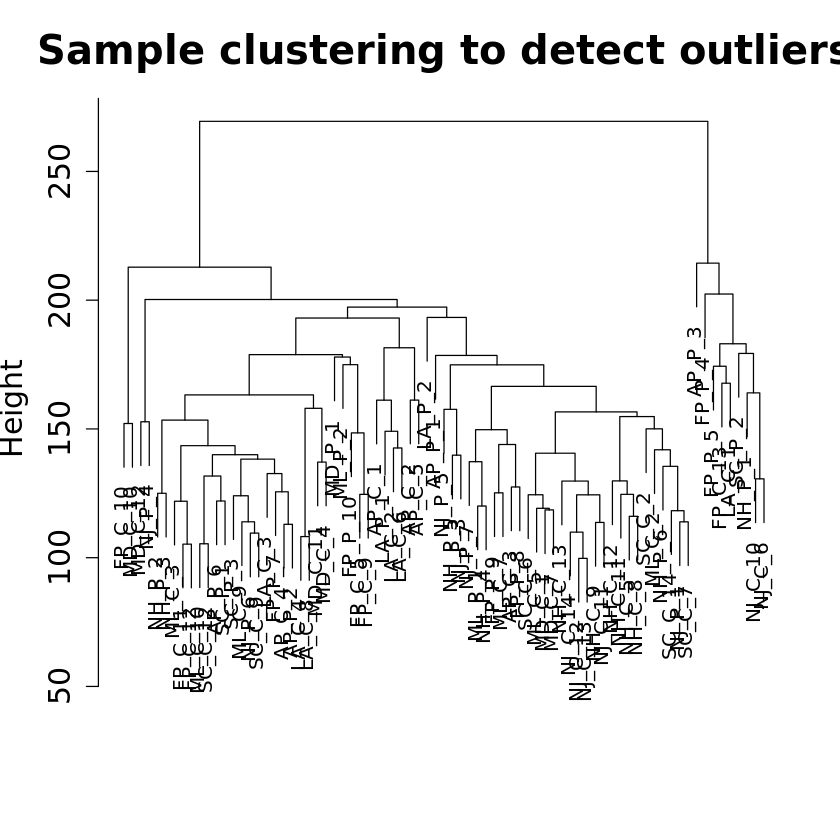

In [6]:
tree = hclust(dist(vsd), method = "average");
plot(tree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
cex.axis = 1.5, cex.main = 2)

Nothing looks too out of the ordinary to get chucked out. Note that this count data already excludes the outliers we removed in DESeq2 (MA control crabs and AP_C_6)

Now we'll load in the sample metadata (same as coldata in DESeq2 analysis).

In [7]:
coldata <- read.table("../metadata/DESeq2_coldata.txt", row.names=1, col.names=c("","site","condition","range","sex"), stringsAsFactors = FALSE)
coldata <- coldata[rownames(vsd),]
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_P_1,AP,P,Native,F


[1] 77  4

The data in this data.frame are all of class 'character' and represent categorical variables. WGCNA was originally constructed to look for correlations between expression modules and numeric trait data (i.e. levels of some disease biomarker, etc). Fortunately, the creators included functions to binarize combinations of categorical data so that we can compare among groups. We will use these later when looking more in depth at comparisons among specific combinations of variables (i.e. range and infection status). The initial comparison will be of just parasitized vs. uninfected, which, being binary, is easy to transform.  We'll subset the coldata to just include the condition and binarize it.

In [8]:
coldata_PvC <- coldata[,2,drop=FALSE]
coldata_PvC$condition[coldata_PvC$condition=='P'] <- 1
coldata_PvC$condition[coldata_PvC$condition=='C'] <- 0
coldata_PvC$condition <- as.numeric(coldata_PvC$condition)
head(coldata_PvC,10)

,condition
AP_C_1,0
AP_C_2,0
AP_C_3,0
AP_C_4,0
AP_C_5,0
AP_P_1,1
AP_P_2,1
AP_P_3,1
AP_P_6,1
FP_C_10,0


Okay looks good. Now we'll have a look at the tree with the infection state colored across samples.

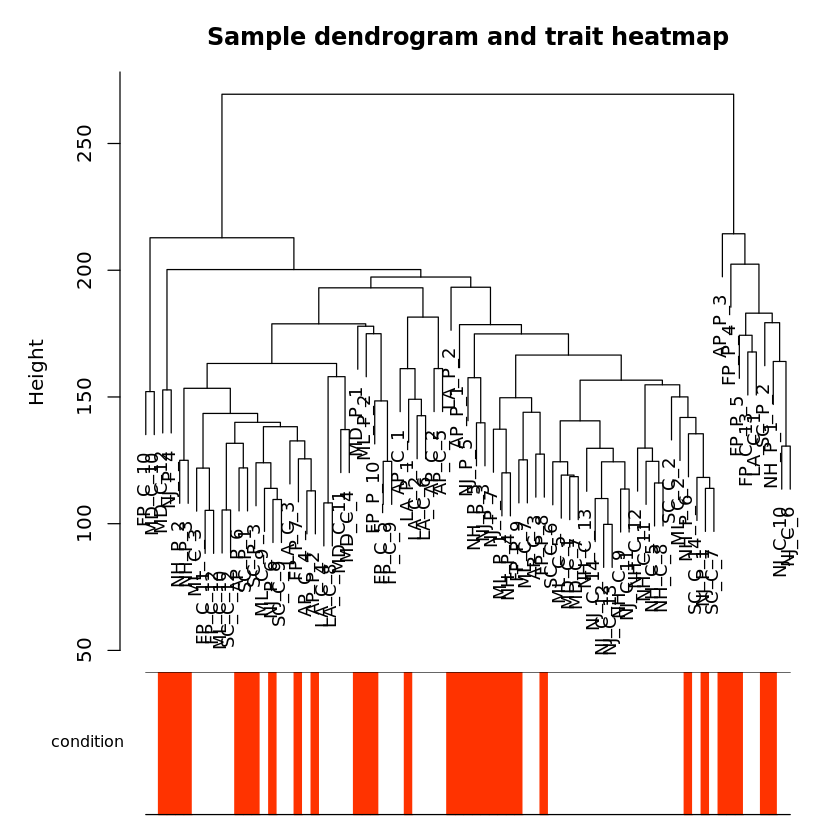

In [9]:
tree2 = hclust(dist(vsd), method = "average")
traitColors = numbers2colors(coldata_PvC, signed = FALSE)
plotDendroAndColors(tree2, traitColors,
    groupLabels = names(coldata_PvC),
    main = "Sample dendrogram and trait heatmap")

Again, as we saw earlier, the samples don't cluster according to infection status when starting from a distance matrix created from the entire matrix of counts. There is just so much other variation present in the data that infection status doesn't stand out so much. This analysis should help resolve which co-expressed groups of transcripts are related to infection status. 

Now we're set up, let's start the actually calculations. First we'll enable multi-threading.

In [10]:
enableWGCNAThreads()

Allowing parallel execution with up to 35 working processes.


Then we'll start with actually performing these calculations. Note that these requires a lot of memory. Make sure to request as much memory as possible when starting up your `srun` session. I requested 24 threads and 180gb RAM. Probably overkill, but I didn't get booted off the node. 

In [11]:
sft = pickSoftThreshold(vsd, verbose = 5, networkType="signed")

pickSoftThreshold: will use block size 1027.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1027 of 43545
   ..working on genes 1028 through 2054 of 43545
   ..working on genes 2055 through 3081 of 43545
   ..working on genes 3082 through 4108 of 43545
   ..working on genes 4109 through 5135 of 43545
   ..working on genes 5136 through 6162 of 43545
   ..working on genes 6163 through 7189 of 43545
   ..working on genes 7190 through 8216 of 43545
   ..working on genes 8217 through 9243 of 43545
   ..working on genes 9244 through 10270 of 43545
   ..working on genes 10271 through 11297 of 43545
   ..working on genes 11298 through 12324 of 43545
   ..working on genes 12325 through 13351 of 43545
   ..working on genes 13352 through 14378 of 43545
   ..working on genes 14379 through 15405 of 43545
   ..working on genes 15406 through 16432 of 43545
   ..working on genes 16433 through 17459 of 43545
   ..working on genes 17460 through 18486 of 

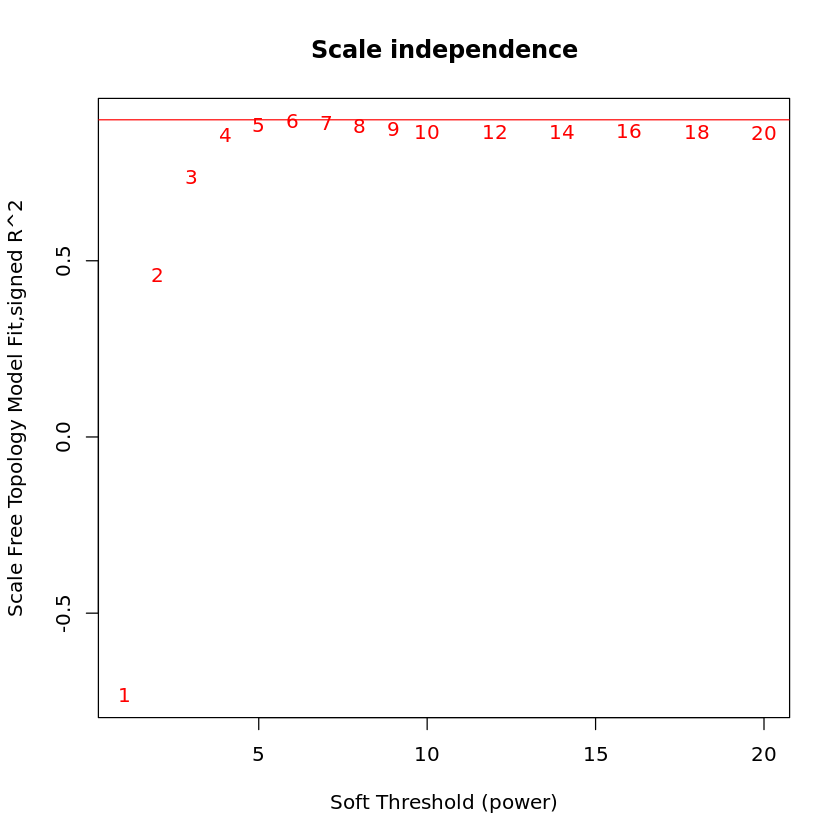

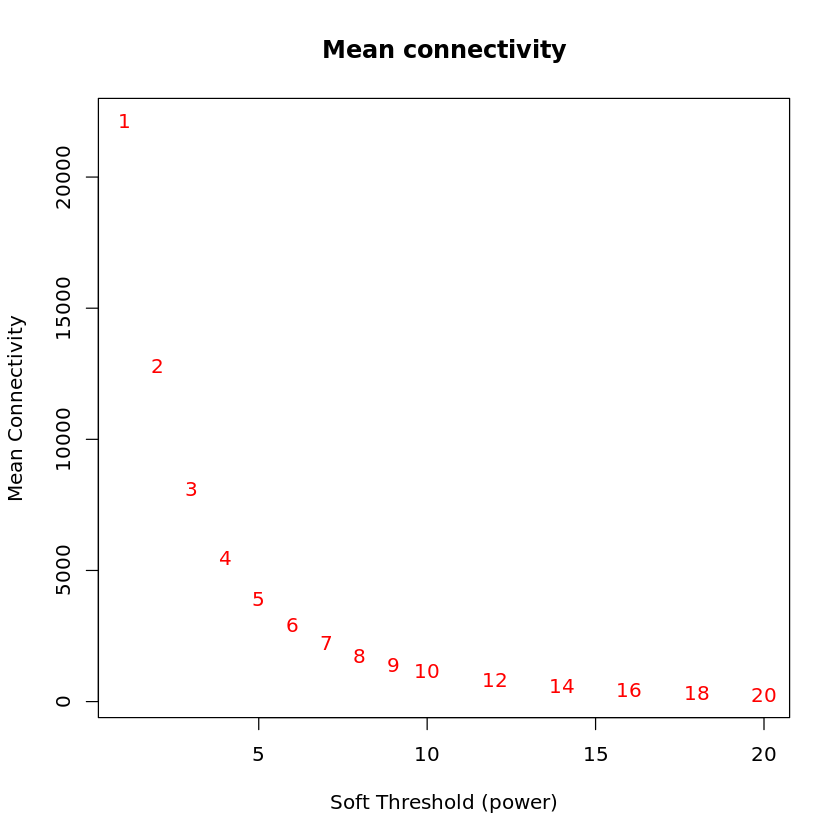

In [12]:
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
    xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
    main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
    labels=c(seq(1, 10, by = 1), seq(12, 20, by = 2)),col="red") #labels from default for power vector
abline(h=0.90,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
    xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
    main = paste("Mean connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,5], labels=c(seq(1, 10, by = 1), seq(12, 20, by = 2)), col="red")

We are going to pick a power of 6, as it is the first value to reach the plateau at ~0.9, as [recommended](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-auto.pdf). It's also the highest value overall, as the $r^{2}$ drops after a power of 6. 

Now we'll do the module construction. 

In [ ]:
library(flashClust)
adjacency = adjacency(vsd, power = 6,type="signed")
TOM = TOMsimilarityFromExpr(vsd,networkType = "signed", TOMType = "signed", power = 6)
dissTOM = 1-TOM
geneTree = flashClust(as.dist(dissTOM),method="average")
save(dissTOM,geneTree,file="signedDissTOM_tree.RData")


Attaching package: ‘flashClust’

The following object is masked from ‘package:fastcluster’:

    hclust

The following object is masked from ‘package:stats’:

    hclust



TOM calculation: adjacency..
..will use 35 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [15]:
#net = blockwiseModules(vsd, power = 6,
#    TOMType = "signed", minModuleSize = 30,
#    reassignThreshold = 0, mergeCutHeight = 0.25,
#    numericLabels = TRUE, pamRespectsDendro = FALSE,
#    saveTOMs = TRUE, networkType = "signed",
#    verbose = 3, maxBlockSize = 45000
#)
#save(net, file="net.RData")

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 35 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file blockwiseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 5885 genes from module 1 because their KME is too low.
     ..removing 2570 genes from module 2 because their KME is too low.
     ..removing 253 genes from module 3 because their KME is too low.
     ..removing 15 genes from module 4 because their KME is too low.
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


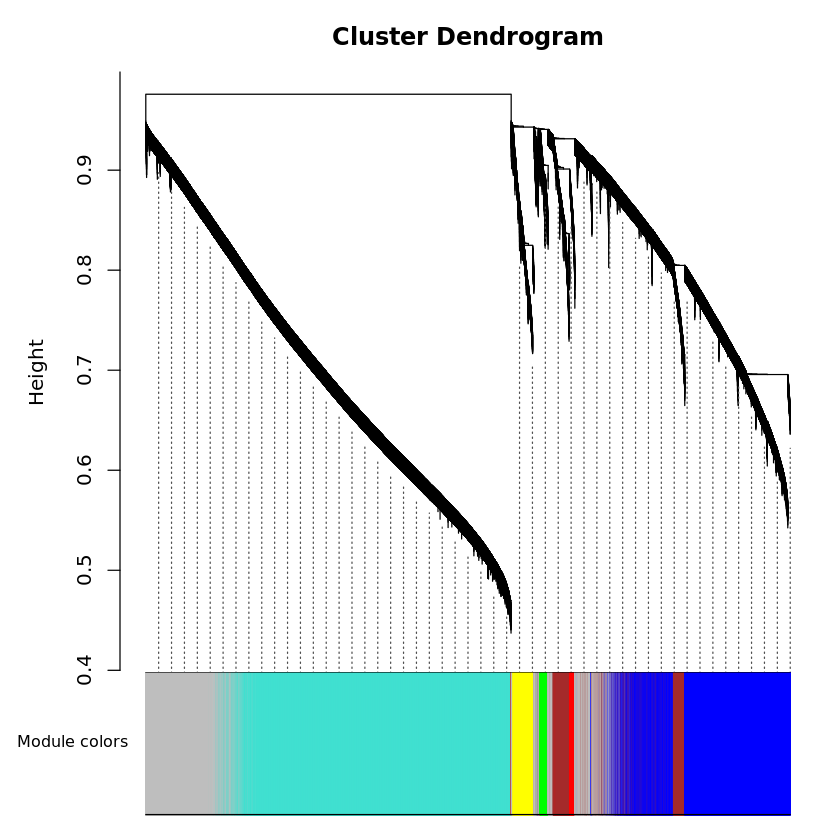

In [19]:
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
"Module colors",
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

In [18]:
table(net$colors)


    0     1     2     3     4     5     6 
 8723 18854 10759  2879  1414   535   381 

We're going to want to have a column that indicates the combination of range and condition. 

USE PASTE!